# Classifiers on Extracted Features
In this notebook the features extracted from the "Transfer Learning" notebook are used for training and evaluating different types of classifiers.

## Useful imports

In [1]:
from google.colab import drive
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow import keras

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Utils

In [ ]:
def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


def evaluate_model (model, X_test, y_test):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  '''
  y_score = model.predict(X_test)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = y_test
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
def compile_model(model, optimizer='adam'):
  loss = 'binary_crossentropy'
  
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
  
GLOBAL_MODELS_FOLDER = '/content/drive/MyDrive/Quora/Models/Transfer Learning/'
HISTORIES_FOLDER = '/content/drive/MyDrive/Quora/Histories/Transfer Learning/'

def run_model (model, model_name, train_set, val_set, epochs = 4, monitor='val_loss', class_weight=None):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = GLOBAL_MODELS_FOLDER + model_name + '.h5'
  callbacks_list = [
                    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                  tf.keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(x=train_ds,
                      validation_data=val_ds,
                      epochs=epochs,
                      callbacks=callbacks_list,
                      class_weight=class_weight)
  # save on Drive only the best model
  #shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')

  # save on Drive also the history object
  history_df = pd.DataFrame(history.history)
  with open(HISTORIES_FOLDER + model_name + '.csv', mode='w+') as f:
    history_df.to_csv(f)

  show_training_and_validation_performance(history)

## Load classes

In [ ]:
train_questions = pd.read_csv('/content/drive/MyDrive/Quora/Dataset/training.csv')
y_train = train_questions['is_duplicate'].values
del train_questions

val_questions = pd.read_csv('/content/drive/MyDrive/Quora/Dataset/validation.csv')
y_val = val_questions['is_duplicate'].values
del val_questions

test_questions = pd.read_csv('/content/drive/MyDrive/Quora/Dataset/test.csv')
y_test = test_questions['is_duplicate'].values
del test_questions

## Compute weights

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train.tolist())

class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.7919194738672034, 1: 1.3564005569348454}

## Doc2Vec
Retrieve the features extracted from sentence BERT:

In [ ]:
x_train = np.load('/content/drive/MyDrive/Quora/Features/Doc2Vec/training/full_question_doc2vec.npy')
x_val = np.load('/content/drive/MyDrive/Quora/Features/Doc2Vec/validation/full_question_doc2vec.npy')
x_test = np.load('/content/drive/MyDrive/Quora/Features/Doc2Vec/test/full_question_doc2vec.npy')

Augment training set:

In [ ]:
q1 = np.load('/content/drive/MyDrive/Quora/Features/Doc2Vec/training/question1_doc2vec.npy')
q2 = np.load('/content/drive/MyDrive/Quora/Features/Doc2Vec/training/question2_doc2vec.npy')

In [ ]:
questions_features = np.zeros((323431, 200))  
for i in range(q1.shape[0]):
  questions_features[i] = np.concatenate([np.array(q2[i]), np.array(q1[i])])

In [ ]:
x_train_aug = np.concatenate([x_train, questions_features])
np.save('/content/drive/MyDrive/Quora/Features/Doc2Vec/training/augmentation_doc2vec.npy', x_train_aug)

In [ ]:
del x_train
x_train = np.load('/content/drive/MyDrive/Quora/Features/Doc2Vec/training/augmentation_doc2vec.npy')
y_train = np.concatenate([y_train, y_train])

In [ ]:
del q1
del q2
del x_train_aug
del questions_features

In [ ]:
del i

In [ ]:
import gc
gc.collect()

22292

Dataset creation:

In [ ]:
BATCH_SIZE = 128

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

In [ ]:
del x_val
del x_train
del y_train
del y_val

gc.collect()

153

### Neural Network with pace 16


In [2]:
def nn_pace16(feature_dimension = 200):
  pace = 16

  input = keras.Input(shape=(feature_dimension,))
  dim = feature_dimension-pace
  x = keras.layers.Dense(dim, activation='relu', name='Dense184')(input)
  while dim != 8:
      dim -= pace
      name = 'Dense' + str(dim)
      x = keras.layers.Dense(dim, activation='relu', name=name)(x)
  outputs = keras.layers.Dense(1, activation='sigmoid', name='prediction')(x)
  model = keras.Model(inputs=input, outputs=outputs)
  return model

In [3]:
model = nn_pace16()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 Dense184 (Dense)            (None, 184)               36984     
                                                                 
 Dense168 (Dense)            (None, 168)               31080     
                                                                 
 Dense152 (Dense)            (None, 152)               25688     
                                                                 
 Dense136 (Dense)            (None, 136)               20808     
                                                                 
 Dense120 (Dense)            (None, 120)               16440     
                                                                 
 Dense104 (Dense)            (None, 104)               12584 

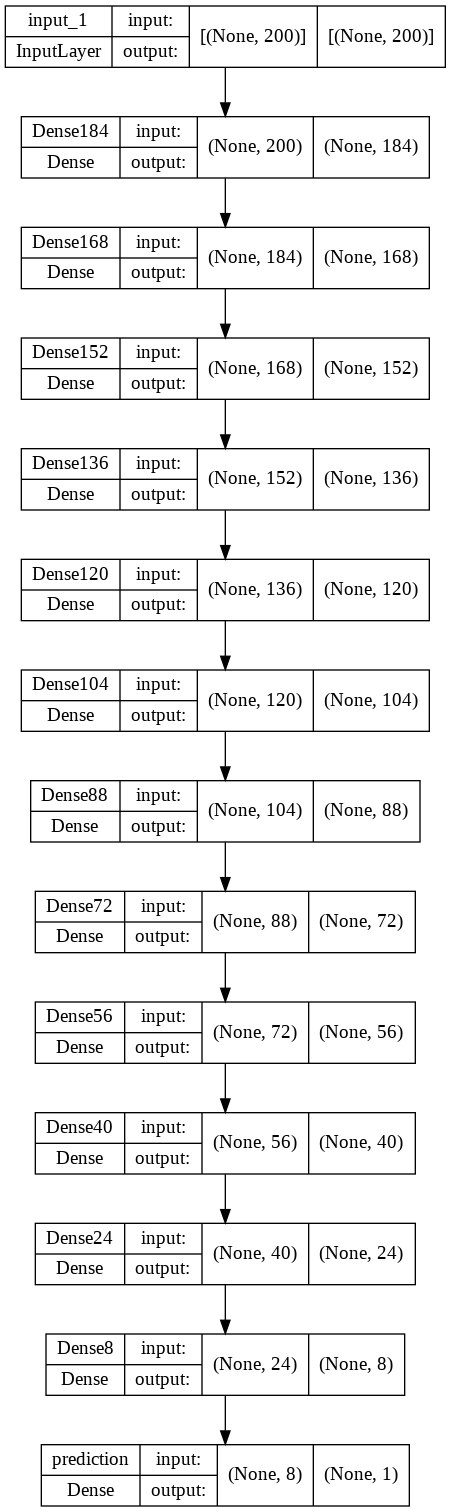

In [4]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
compile_model(model)

#### Experiment 1
In this experiment we use the original train_ds and val_ds for training.

Epoch 1/20
2518/2527 [============================>.] - ETA: 0s - loss: 0.5579 - accuracy: 0.7036
Epoch 1: val_loss improved from inf to 0.53028, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/doc2vec_DL_pace16.h5
2527/2527 [==============================] - 30s 10ms/step - loss: 0.5578 - accuracy: 0.7037 - val_loss: 0.5303 - val_accuracy: 0.7255
Epoch 2/20
2520/2527 [============================>.] - ETA: 0s - loss: 0.5211 - accuracy: 0.7299
Epoch 2: val_loss improved from 0.53028 to 0.51603, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/doc2vec_DL_pace16.h5
2527/2527 [==============================] - 15s 6ms/step - loss: 0.5211 - accuracy: 0.7299 - val_loss: 0.5160 - val_accuracy: 0.7372
Epoch 3/20
2517/2527 [============================>.] - ETA: 0s - loss: 0.5025 - accuracy: 0.7434
Epoch 3: val_loss improved from 0.51603 to 0.51581, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/doc2vec_DL_pace16.h5
2527/2527 [=

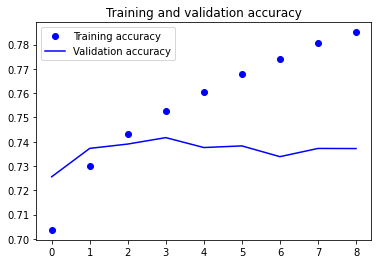

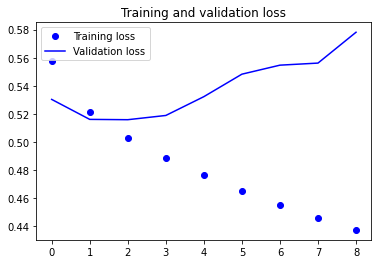

In [ ]:
run_model(model, 'doc2vec_DL_pace16', train_ds, val_ds, epochs=20)

Classification report: 
              precision    recall  f1-score   support

           0     0.9035    0.8640    0.8833     25348
           1     0.7871    0.8449    0.8150     15080

    accuracy                         0.8569     40428
   macro avg     0.8453    0.8545    0.8491     40428
weighted avg     0.8601    0.8569    0.8578     40428



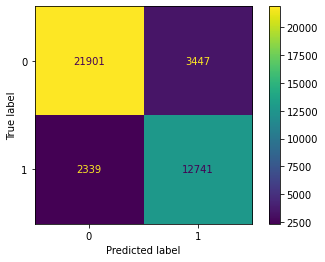

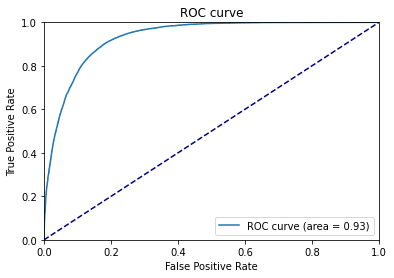

In [ ]:
evaluate_model(model, x_test, y_test)

#### Experiment 2: using class_weights

Epoch 1/20
2518/2527 [============================>.] - ETA: 0s - loss: 0.5836 - accuracy: 0.6829
Epoch 1: val_loss improved from inf to 0.54453, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/doc2vec_DL_pace16_weighted.h5
2527/2527 [==============================] - 13s 5ms/step - loss: 0.5835 - accuracy: 0.6829 - val_loss: 0.5445 - val_accuracy: 0.7151
Epoch 2/20
2525/2527 [============================>.] - ETA: 0s - loss: 0.5422 - accuracy: 0.7113
Epoch 2: val_loss improved from 0.54453 to 0.53423, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/doc2vec_DL_pace16_weighted.h5
2527/2527 [==============================] - 13s 5ms/step - loss: 0.5422 - accuracy: 0.7113 - val_loss: 0.5342 - val_accuracy: 0.7112
Epoch 3/20
2520/2527 [============================>.] - ETA: 0s - loss: 0.5214 - accuracy: 0.7261
Epoch 3: val_loss improved from 0.53423 to 0.52771, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/doc2vec_DL_pace1

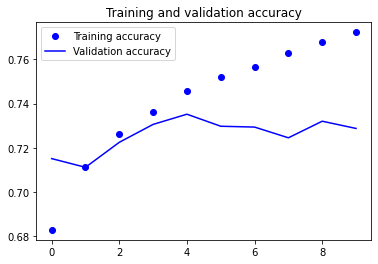

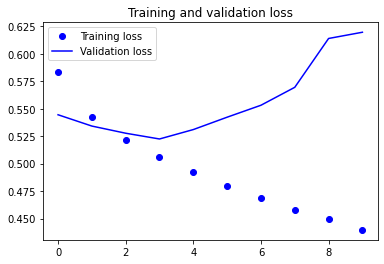

In [ ]:
run_model(model, 'doc2vec_DL_pace16_weighted', train_ds, val_ds, epochs=20, class_weight=class_weights)

Classification report: 
              precision    recall  f1-score   support

           0     0.8166    0.7350    0.7737     25348
           1     0.6186    0.7226    0.6666     15080

    accuracy                         0.7304     40428
   macro avg     0.7176    0.7288    0.7201     40428
weighted avg     0.7428    0.7304    0.7337     40428



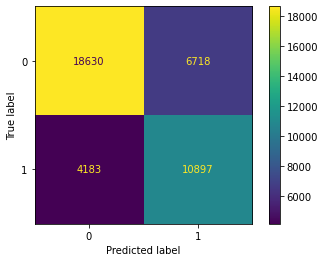

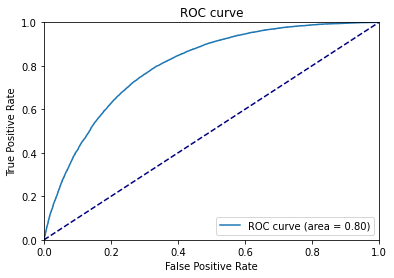

In [ ]:
evaluate_model(model, x_test, y_test)

#### Experiment 3: augmentation

Epoch 1/20
5052/5054 [============================>.] - ETA: 0s - loss: 0.5440 - accuracy: 0.7135
Epoch 1: val_loss improved from inf to 0.52175, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/doc2vec_DL_pace16_aug.h5
5054/5054 [==============================] - 24s 4ms/step - loss: 0.5440 - accuracy: 0.7135 - val_loss: 0.5217 - val_accuracy: 0.7271
Epoch 2/20
5053/5054 [============================>.] - ETA: 0s - loss: 0.5086 - accuracy: 0.7391
Epoch 2: val_loss improved from 0.52175 to 0.50850, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/doc2vec_DL_pace16_aug.h5
5054/5054 [==============================] - 24s 5ms/step - loss: 0.5086 - accuracy: 0.7391 - val_loss: 0.5085 - val_accuracy: 0.7392
Epoch 3/20
5053/5054 [============================>.] - ETA: 0s - loss: 0.4927 - accuracy: 0.7504
Epoch 3: val_loss improved from 0.50850 to 0.50288, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/doc2vec_DL_pace16_aug.h5
5

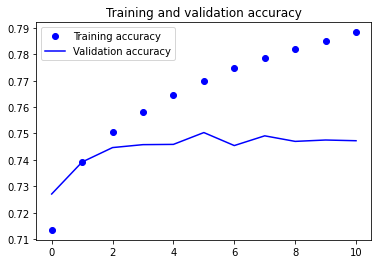

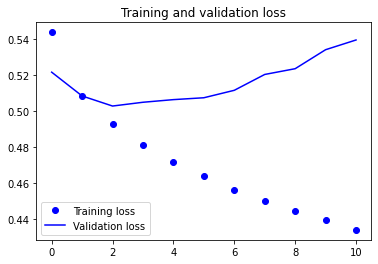

In [ ]:
run_model(model, 'doc2vec_DL_pace16_aug', train_ds, val_ds, epochs=20)

Classification report: 
              precision    recall  f1-score   support

           0     0.7818    0.8261    0.8034     25348
           1     0.6770    0.6125    0.6432     15080

    accuracy                         0.7465     40428
   macro avg     0.7294    0.7193    0.7233     40428
weighted avg     0.7427    0.7465    0.7436     40428



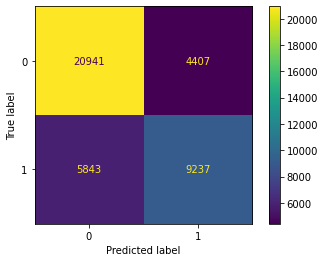

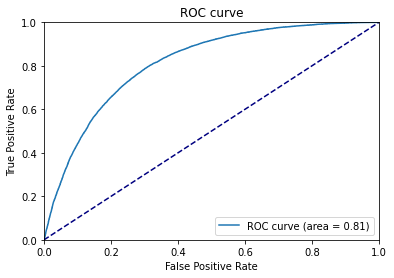

In [ ]:
evaluate_model(model, x_test, y_test)

#### Experiment 4: augmentation + class weights

Epoch 1/20
5048/5054 [============================>.] - ETA: 0s - loss: 0.5814 - accuracy: 0.6802
Epoch 1: val_loss improved from inf to 0.53581, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/doc2vec_DL_pace16_aug_weighted.h5
5054/5054 [==============================] - 24s 5ms/step - loss: 0.5814 - accuracy: 0.6803 - val_loss: 0.5358 - val_accuracy: 0.7167
Epoch 2/20
5049/5054 [============================>.] - ETA: 0s - loss: 0.5391 - accuracy: 0.7125
Epoch 2: val_loss improved from 0.53581 to 0.51960, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/doc2vec_DL_pace16_aug_weighted.h5
5054/5054 [==============================] - 23s 5ms/step - loss: 0.5391 - accuracy: 0.7125 - val_loss: 0.5196 - val_accuracy: 0.7316
Epoch 3/20
5044/5054 [============================>.] - ETA: 0s - loss: 0.5210 - accuracy: 0.7260
Epoch 3: val_loss improved from 0.51960 to 0.51615, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/doc2vec_

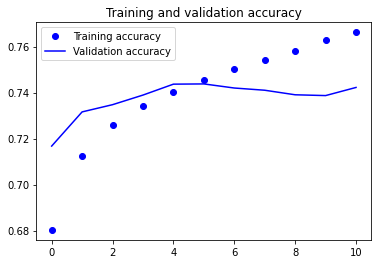

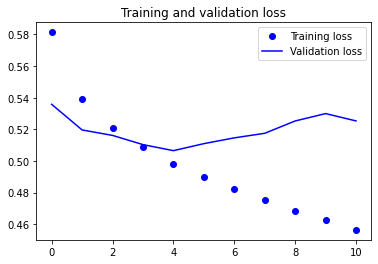

In [ ]:
run_model(model, 'doc2vec_DL_pace16_aug_weighted', train_ds, val_ds, epochs=20, class_weight=class_weights)

Classification report: 
              precision    recall  f1-score   support

           0     0.8185    0.7520    0.7838     25348
           1     0.6332    0.7198    0.6737     15080

    accuracy                         0.7400     40428
   macro avg     0.7259    0.7359    0.7288     40428
weighted avg     0.7494    0.7400    0.7428     40428



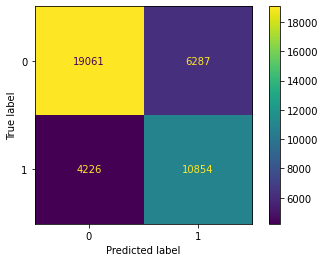

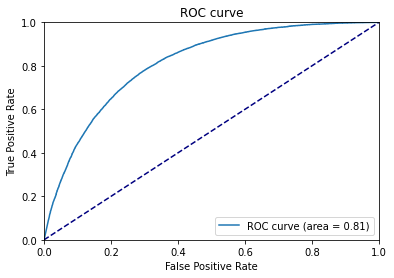

In [ ]:
evaluate_model(model, x_test, y_test)